# Analysis of users' behaviour in a hypothetical free-to-play mobile game

# Part 1: Introduction

## Description

Hello! My name is Anastasiia Murashova, and my goal is to enroll into Data Analysis. I have previous experience in software engineering using Python, and I want to expand my expertise to start a new career after moving to Finland, EU.

Here is my Linkedin page: https://www.linkedin.com/in/anastasiiamurashova/

This is the test task from Supercell company; the deadline passed on 30th November 2023. I have expanded it after completing it and want to share it to showcase my data analytical skills.

The work is divided into several parts, and this is the first part. The goal is to analyze the mobile game data, users' behaviuor and their ability to make purchases.

This notebook represents a test database consisting of three tables and analyzes users' behavior in the game.

Link to the task description and data https://www.dropbox.com/scl/fi/kcixwvtjg3ydtpylypdbe/Localization-Data-Intern-Test.pdf?rlkey=uifet3rmmcefyfmzd5p9ndt9g&dl=0

## Loading libs and data

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry

from matplotlib import rc
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import *
from scipy.spatial.distance import pdist
from pandas.plotting import scatter_matrix

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

Load the data and transform it for work in Jupyter Notebook

In [2]:
con = sqlite3.connect("sample.sqlite")

In [3]:
acc_df = pd.read_sql_query("SELECT * FROM account", con)
ses_df = pd.read_sql_query("SELECT * FROM account_date_session", con)
iap_df = pd.read_sql_query("SELECT * FROM iap_purchase", con)

Looking through the tables

In [4]:
acc_df.head()

,account_id,created_time,created_device,created_platform,country_code,created_app_store_id
0,13514010,2016-03-02 17:11:00.332,"iPhone6,2",iOS,GB,1
1,4308483975,2016-03-02 20:57:46.14,MIDC147PJ,Android,FR,2
2,17193137415,2016-03-02 13:52:16.735,SM-G360F,Android,IT,2
3,21488104920,2016-03-02 12:43:27.899,H60-L01,Android,CN,8
4,21488107995,2016-03-02 17:20:12.145,GT-I9500,Android,RU,2


Fisrt table "account" named here "acc_df" shows account id of mobile game user, data and time when account has created, the device model and the platfrom of the device used to create account, code of country where accound has been registered and id, created in application store of the platfrom

In [5]:
ses_df.head()

,account_id,date,session_count,session_duration_sec
0,68730811144,2016-01-01,1,47
1,68730812806,2016-01-01,1,204
2,68730829426,2016-01-01,12,4703
3,68730829426,2016-01-02,9,4676
4,68730829426,2016-01-03,9,2271


Second table "account_date_session" named here "ses_df" shows account id of mobile game user, data when account has created, the amount of sessions and its duration spent playing the game

In [6]:
iap_df.head()

,account_id,created_time,package_id_hash,iap_price_usd_cents,app_store_id
0,30077202816,2016-03-26 23:59:59.355,ae0253c27c34edd1ab4fe21d6bfc91f8,739,0
1,30077202816,2016-05-31 11:24:37.283,dd4c1bda4f2c904075fb2fbfcf30f30e,369,0
2,21487283560,2016-02-13 03:40:28.644,99a9e0e63efa2fdce8fc8de74c66cea9,184,0
3,21487152816,2016-02-28 00:53:26.678,99a9e0e63efa2fdce8fc8de74c66cea9,184,0
4,8602037685,2016-02-11 01:03:04.727,99a9e0e63efa2fdce8fc8de74c66cea9,184,0


Third table "iap_purchase" named here "iap_df" shows account id of mobile game user, data and time when user has purchase an item, the hash id of purchased item, the price of purchased item and the id in application store of purchased item


After looking through the data, we observed a relational database consisting of three tables with the foreign key "account_id." This key represents the account ID of every user in the mobile game.

### Analysis of the number of accounts

In [8]:
print('Amount of all users is ' + str(acc_df['account_id'].nunique()))

Amount of all users is 112792


In [9]:
print('Amount of active users which actually played game is ' + str(ses_df['account_id'].nunique()))

Amount of active users which actually played game is 112451


In [11]:
print('Amount of users made purchases in the game is ' + str( iap_df['account_id'].nunique() ))

Amount of users made purchases in the game is 1549


Numbers of unique accounts says that it's only 1% of users which involved in purchases and there's less than 0.1% inactive users at all, they don't participate in sessions.

### Hipothesуs formed before conducting user activity analysis

To countinue our analysis we need to define the criteria for daily active user (DAU), for example, app user clicked a button, swiped, or scrolled, and then calculate the frequency of these actions.

We don’t have data about whether users went somewhere and what buttons they pressed or not, we only have time spent in the application.

The company, obviously, needs profit, but people are involved in using the application more than simply purchasing users, they can watch advertising integrations and then follow referral links, thus providing profit.

Based on this, the majority of our users are active, we cannot exclude the majority of users who do not use in-app purchases, so, let's continue research to find criteria for DAU definition

## Conclusion for the data observation

We observed relational database consist of three tables united with account_id foreign key. Tables show us data about users' accounts, time spent in the application and purchases made in application. Fisrt glance at the data and the fact of lack the information about user interactions in the game such as pressing buttons, doesn't allow to find criteria for DAU calculation right away.

# Part 2: DAU analysis

This is the second part. The goal is to analyze the mobile game data, users' behaviuor and their ability to make purchases and represents DAU calculations based on users' behavior analysis in the game.

## Sessions duration analysis

Let's create diagrams displaying the distribution of session durations in seconds. These diagrams will show us the majority of durations and outliers.

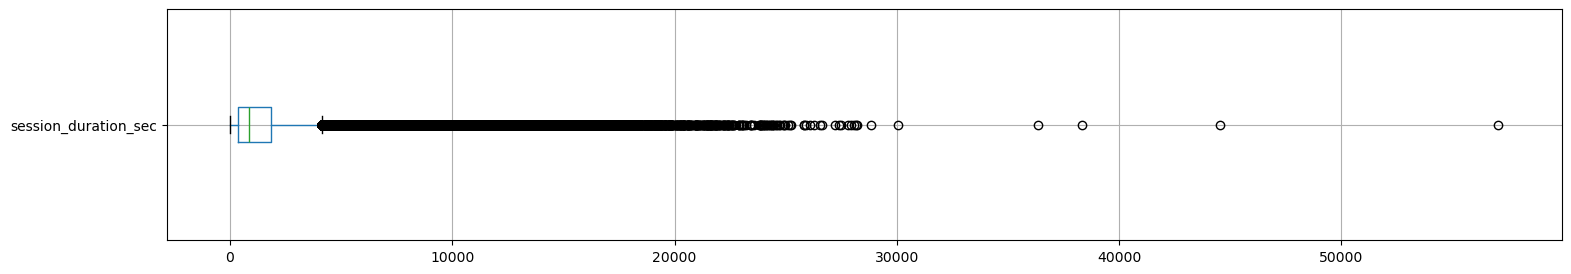

In [12]:
boxplot = ses_df.boxplot(column=['session_duration_sec'], figsize = (18, 3), vert = False)  

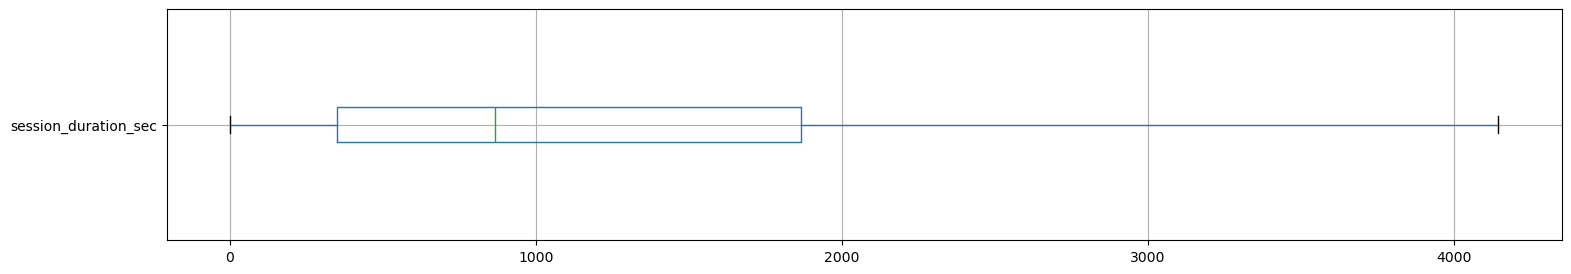

In [13]:
boxplot_no_out = ses_df.boxplot(column=['session_duration_sec'], figsize = (18, 3), vert = False, showfliers=False)
plt.show()

In [14]:
ses_df['session_duration_sec'].describe()

count    1.698974e+06
mean     1.434244e+03
std      1.715709e+03
min      1.000000e+00
25%      3.490000e+02
50%      8.660000e+02
75%      1.867000e+03
max      5.705000e+04
Name: session_duration_sec, dtype: float64

As we see, there are a lot of outliers from the typical session duration. The majority fall within the range of 0 to 4000+ seconds. The mean session duration is 1434 seconds, and 50% of all sessions last 866 seconds.

Take a closer look at the histogram of the amount of different session durations

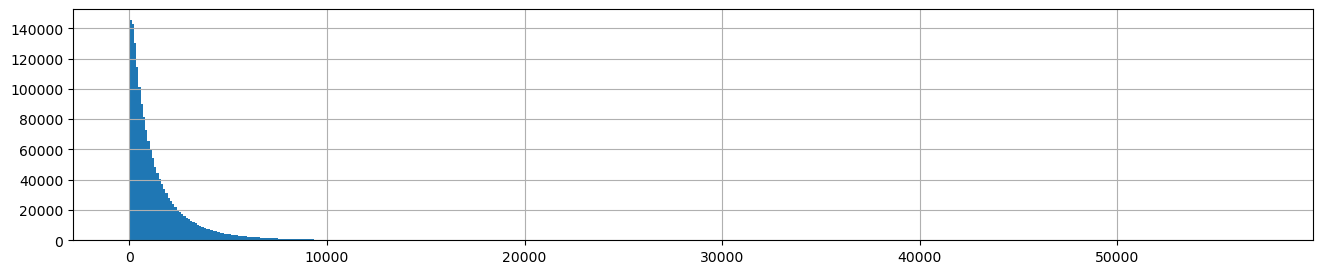

In [15]:
session_hist = ses_df['session_duration_sec'].hist(bins=500, figsize = (16, 3))
plt.show()

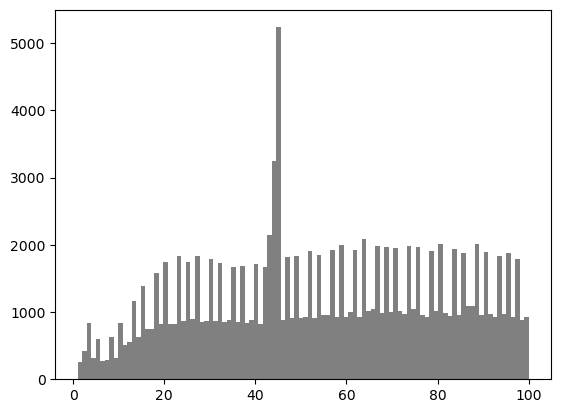

In [16]:
plt.hist(ses_df['session_duration_sec'], 100, range=[1, 100], facecolor='gray', align='mid')
plt.show()

We see the huge spike in the range at about 46 seconds, I wonder if this is a conditionally active session, can a session of this length be considered a short gaming session, is there a session length that we can neglect? Are long-lasting outliers due to an active session or did the user forget the phone with the game on?

Since we do not have detailed data on how users interact with the application, we will take this outlier at 46 seconds, round it up to 50 and consider it a sufficient criteria for not counting users with sessions shorter than 50 seconds as active.

## Definition and extraction of the Daily Active Users (DAU) share

####  So, as we do not have any specific characteristics for user activity besides my assumption of 50 seconds border rule for DAU, the only thing I can do is to show amount user in every day who has avtive sessions through the year and share of them

Making country matching depending on its two-letter code

In [18]:
codes_to_countries = {}
for country in pycountry.countries:
    codes_to_countries[country.alpha_2] = country.name 

def match_country_name(x):
    try:
        return codes_to_countries[x]
    except:
        return np.NaN
    
acc_df['created_country'] = acc_df['country_code'].apply(match_country_name)
acc_df.head()

,account_id,created_time,created_device,created_platform,country_code,created_app_store_id,created_country
0,13514010,2016-03-02 17:11:00.332,"iPhone6,2",iOS,GB,1,United Kingdom
1,4308483975,2016-03-02 20:57:46.14,MIDC147PJ,Android,FR,2,France
2,17193137415,2016-03-02 13:52:16.735,SM-G360F,Android,IT,2,Italy
3,21488104920,2016-03-02 12:43:27.899,H60-L01,Android,CN,8,China
4,21488107995,2016-03-02 17:20:12.145,GT-I9500,Android,RU,2,Russian Federation


Now we can see actual name of countries what makes further analysis more observable

Making dataframe which allows us to understand how many times each user entered the game since date creation of account and how much time each user had played

In [19]:
res_df = ses_df.groupby('account_id').agg({'date':['count', 'min'],
                                                'session_count':'sum',
                                                'session_duration_sec':'sum'})
res_df.columns = list(map('_'.join, res_df.columns.values))
res_df = res_df.rename(columns={'date_count':'dates_num',
                          'date_min':'first_activity_date',
                          'session_count_sum':'total_session_count',
                          'session_duration_sec_sum':'total_session_duration_sec'})
res_df.head()

,dates_num,first_activity_date,total_session_count,total_session_duration_sec
account_id,,,,
12314866,5,2016-01-01,11,3908
12315420,2,2016-01-01,31,19102
12315974,1,2016-01-01,1,151
12316528,134,2016-01-01,383,162666
12317082,1,2016-01-01,1,234


Let's create a pivot dataset to make it easier to analyze users and their actions: the time of their first activity in the application, the time when they had registered, how long they have played, and how many sessions they have had.

In [20]:
total_df = pd.merge(acc_df,
                    res_df,
                    left_on='account_id', right_on='account_id')

total_df['first_activity_date'] = pd.to_datetime(total_df['first_activity_date'], format = 'ISO8601')
total_df['created_time'] = pd.to_datetime(total_df['created_time'], format = 'ISO8601')

total_df['hours_to_first_activity'] = \
(total_df['first_activity_date'] - total_df['created_time']).apply(lambda x: x.seconds/60./60.)

total_df['created_time_days_from_the_beginning_of_year'] = \
(total_df['created_time'] - pd.to_datetime('2016-01-01 00:00:00.000')).apply(lambda x: x.days)

total_df.head()

,account_id,created_time,created_device,created_platform,country_code,created_app_store_id,created_country,dates_num,first_activity_date,total_session_count,total_session_duration_sec,hours_to_first_activity,created_time_days_from_the_beginning_of_year
0,13514010,2016-03-02 17:11:00.332,"iPhone6,2",iOS,GB,1,United Kingdom,15,2016-03-02,72,25681,6.816389,61
1,4308483975,2016-03-02 20:57:46.140,MIDC147PJ,Android,FR,2,France,2,2016-03-02,2,453,3.036944,61
2,17193137415,2016-03-02 13:52:16.735,SM-G360F,Android,IT,2,Italy,24,2016-03-02,35,6478,10.128611,61
3,21488104920,2016-03-02 12:43:27.899,H60-L01,Android,CN,8,China,10,2016-03-02,28,11533,11.275556,61
4,21488107995,2016-03-02 17:20:12.145,GT-I9500,Android,RU,2,Russian Federation,1,2016-03-02,1,42,6.663056,61


Start counting the daily active users share.

As defined before, we consider a session as part of the criteria for DAU when its minimal duration is over 50 seconds.

In [21]:
active_users = total_df['account_id'][total_df['total_session_duration_sec'] > 50].count()
all_users = total_df['account_id'].count()

all_daily_active_users_share = (active_users/all_users).round(3)
print("Share of all daily active users, considering that all sessions less is 50 seconds inactive, \
is " + str(all_daily_active_users_share*100) + "%")


Share of all daily active users, considering that all sessions less is 50 seconds inactive, is 79.9%


## Trends of DAU by seasons

Adding certain dates to existing dataframe

In [22]:
total_df_with_date = pd.merge(total_df,
                              ses_df[['account_id', 'date']],
                              left_on='account_id', right_on='account_id')
total_df_with_date.head()

,account_id,created_time,created_device,created_platform,country_code,created_app_store_id,created_country,dates_num,first_activity_date,total_session_count,total_session_duration_sec,hours_to_first_activity,created_time_days_from_the_beginning_of_year,date
0,13514010,2016-03-02 17:11:00.332,"iPhone6,2",iOS,GB,1,United Kingdom,15,2016-03-02,72,25681,6.816389,61,2016-03-02
1,13514010,2016-03-02 17:11:00.332,"iPhone6,2",iOS,GB,1,United Kingdom,15,2016-03-02,72,25681,6.816389,61,2016-03-03
2,13514010,2016-03-02 17:11:00.332,"iPhone6,2",iOS,GB,1,United Kingdom,15,2016-03-02,72,25681,6.816389,61,2016-03-04
3,13514010,2016-03-02 17:11:00.332,"iPhone6,2",iOS,GB,1,United Kingdom,15,2016-03-02,72,25681,6.816389,61,2016-03-05
4,13514010,2016-03-02 17:11:00.332,"iPhone6,2",iOS,GB,1,United Kingdom,15,2016-03-02,72,25681,6.816389,61,2016-03-06


Convert dates into usable format

In [23]:
total_df_with_date['date'] = pd.to_datetime(total_df_with_date['date'])

Creating quarters depending on the dates and adding them to dataframe, also extracting months

In [24]:
total_df_with_date['quarter'] = total_df_with_date['date'].dt.quarter
total_df_with_date['month'] = total_df_with_date['date'].dt.month

Making lists with counted users, depending on quarters of a year. List with active users we considering as those users who spent more than 50 seconds in the application

In [25]:
active_users_list = [total_df_with_date.query('quarter == @i and total_session_duration_sec > 50').account_id.nunique() for i in range(1, 5)]

In [26]:
inactive_users_list = [total_df_with_date.query('quarter == @i').account_id.nunique() for i in range(1, 5)]

Counting and showing share of active users by quarters

In [27]:
print(f"First quarter's mean active user session is {(active_users_list[0]/inactive_users_list[0])*100}%")

First quarter's mean active user session is 81.40234596433088%


In [28]:
print(f"Second quarter's mean active user session is {(active_users_list[1]/inactive_users_list[1])*100}%")

Second quarter's mean active user session is 84.24033271391912%


In [29]:
print(f"Third quarter's mean active user session is {(active_users_list[2]/inactive_users_list[2])*100}%")

Third quarter's mean active user session is 85.59515972287532%


In [30]:
print(f"Fourth quarter's mean active user session is {(active_users_list[3]/inactive_users_list[3])*100}%")

Fourth quarter's mean active user session is 85.1187678513323%


As we can see, the share of active users from season to season is quite similar and flucruate from to 81.4% to 85.6%, so we don't observe obvious changes here, expect from being less active in the beginning of the year, probably, less people knew about the game.

### General analysis of spent time in application by users

#### Boxplot showing when users do their first activity since account registration.

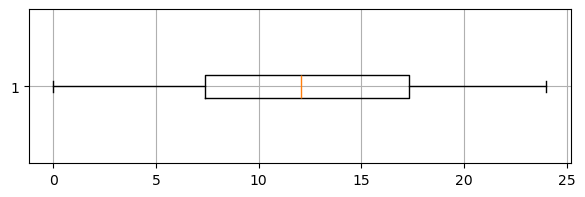

In [31]:
plt.figure(figsize=(7,2))
plt.boxplot(total_df['hours_to_first_activity'], showfliers=False, vert = False)
plt.grid()
plt.show()

Majority (less than 25%) of users do their first action ~7.3 hours after registration, around 50% - ~12 hours after registration and less than 75% - ~17.3 hours after registration

#### Boxplot showing total session duration of users

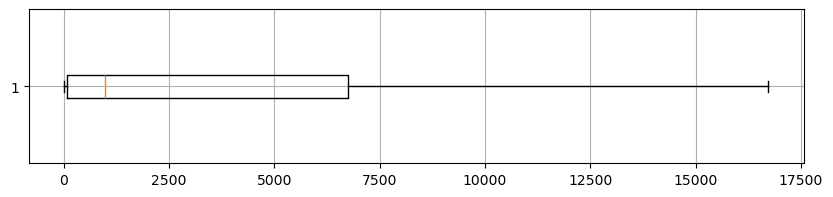

In [32]:
plt.figure(figsize=(10,2))
plt.boxplot(total_df['total_session_duration_sec'], showfliers=False, vert = False)
plt.grid()
plt.show()

Majority of users play insignificant amount of time, simply one second, half of users play 983 sec in total, and less than 75% of users play 6737 sec in total or approximately an hour

#### Boxplot showing distribution amount of sessions for users

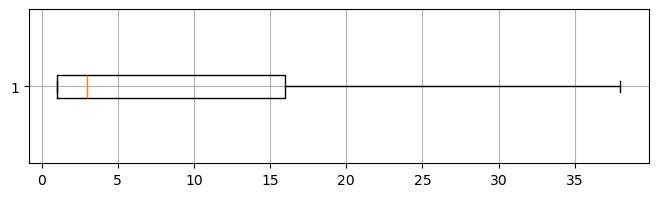

In [33]:
plt.figure(figsize=(8,2))
plt.boxplot(total_df['total_session_count'], showfliers=False, vert = False)
plt.grid()
plt.show()

Minority (less than 75%) of users made ~16 sessions, around 50% 3 sessons and majority of users made just 1 session

#### Boxplot showing the duration of the number of days users spent in sessions in total

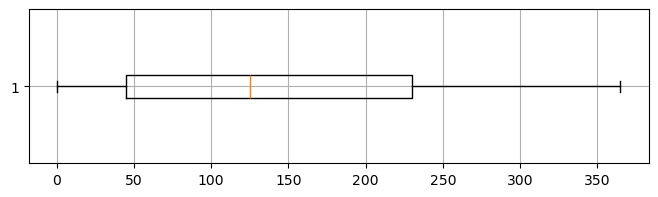

In [34]:
plt.figure(figsize=(8,2))
plt.boxplot(total_df['created_time_days_from_the_beginning_of_year'], showfliers=False, vert = False)
plt.grid()
plt.show()

The majority of sessions and their duration fall in the first quartile of time, that is, mostly users do not conduct sessions for a long time

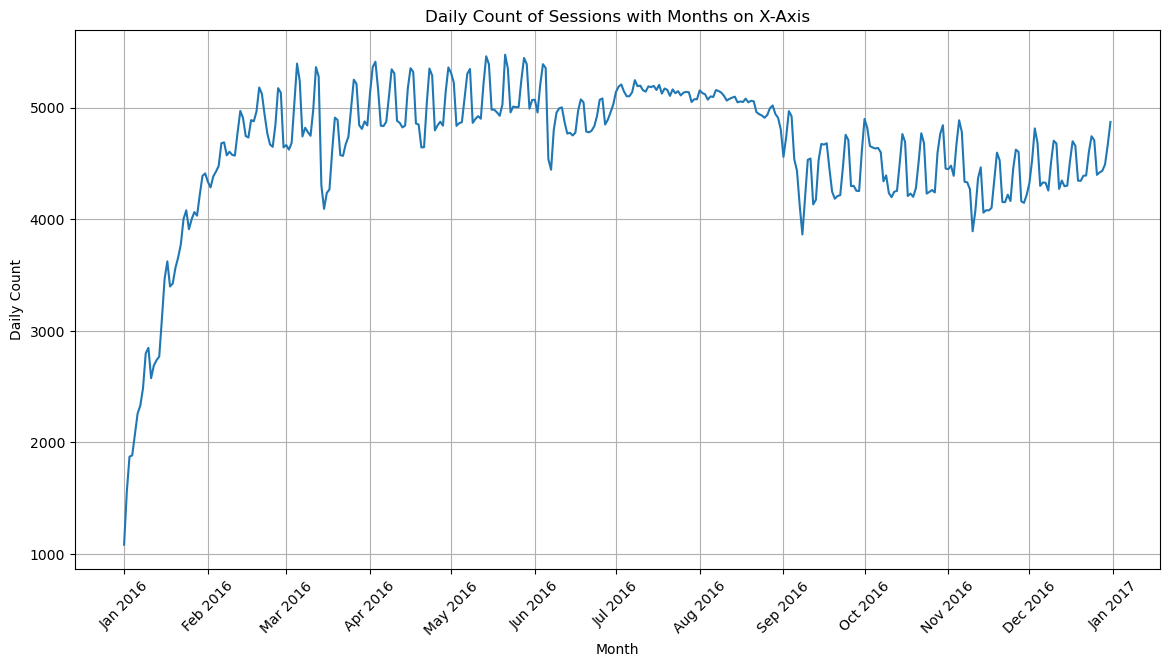

In [35]:
# Group by day (date) and count the occurrences
daily_counts = total_df_with_date.groupby('date').size().reset_index(name='count')

# Plot the data with months on x-axis
plt.figure(figsize=(14, 7))
plt.plot(daily_counts['date'], daily_counts['count'], linestyle='-')

# Formatting the x-axis to show months
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Daily Count')
plt.title('Daily Count of Sessions with Months on X-Axis')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)

# Show the plot
plt.show()

## Conclusions after users activity analysis

1. Our DAU is 79.9%, and seasonal DAU of its is between 81.4% and 85.6%, which says about high loyality amoung users
2. Only 1% of users make purchases
3. Within outliers, majority of users plays once, total less than 1000 seconds in period between March and July
4. We see huge increase of total active users in the beginning of the year so probably it may be cause of launch new version, item or including new regions availiable for the game

# Part 3: Sales analysis

The goal is to analyze the mobile game data, users' behaviuor and their ability to make purchases

## Clusterisation analysis

I want to try to figure out if I could find any behavioural groups among the data, so I delete date columns to get more unique rows and to fill NaNs

In [36]:
total_df_no_date = total_df_with_date.drop(['date', 'quarter', 'month'], axis=1)
total_df_no_date.drop_duplicates(inplace=True) #(keep=False, inplace=False)
total_df_no_date[total_df_no_date.isnull().any(axis=1)]

,account_id,created_time,created_device,created_platform,country_code,created_app_store_id,created_country,dates_num,first_activity_date,total_session_count,total_session_duration_sec,hours_to_first_activity,created_time_days_from_the_beginning_of_year
28230,17192655758,2016-02-02 06:16:01.596,SM-G7102,Android,None,2,NaN,3,2016-02-02,11,4075,17.732778,32
77174,51555085488,2016-11-16 09:48:37.114,Micromax Q381,Android,None,2,NaN,3,2016-11-16,3,1113,14.189444,320
116080,68734911150,2016-11-12 08:19:15.130,SAMSUNG-SM-N900A,Android,None,2,NaN,1,2016-11-12,1,51,15.678889,316
141922,64437771552,2016-04-28 23:18:14.175,MotoG3,Android,None,2,NaN,62,2016-04-28,143,42422,0.695833,118
157514,64439379177,2016-09-16 21:09:51.784,PGN513,Android,None,2,NaN,1,2016-09-16,1,279,2.835556,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639010,47257601490,2016-02-21 13:46:26.873,SM-T113,Android,None,2,NaN,16,2016-02-21,27,10630,10.225833,51
1668675,8605429524,2016-09-05 06:20:28.244,Lenovo A1000,Android,None,2,NaN,1,2016-09-05,1,33,17.658611,248
1676942,38670612940,2016-11-02 05:33:56.533,iris402+,Android,None,2,NaN,1,2016-11-02,1,1388,18.434167,306
1684277,60145255302,2016-12-10 15:36:05.903,2014818,Android,None,2,NaN,1,2016-12-10,1,57,8.398333,344


In [37]:
total_df_no_date = total_df_no_date.fillna({"country_code": 0, "created_country":"Unknown"})

Then I merge my dataframe with info about purchases

In [38]:
merged = pd.merge(total_df_no_date, iap_df, on='account_id', how='outer')

Marking with 0 and 1 absence and presence of purchase

In [39]:
merged['purchase'] = np.where(merged['iap_price_usd_cents'].notnull(), 1, 0)

In [40]:
merged = merged.fillna(0)

As we know that parameters for clusterisation shoud be quantitive, not nominative, I choose a range of varieties like amount of sessions, hours to first activity, when each account was created and purchase indicator

In [44]:
eg_col = ['total_session_count', 'hours_to_first_activity', 'created_time_days_from_the_beginning_of_year', 'purchase']

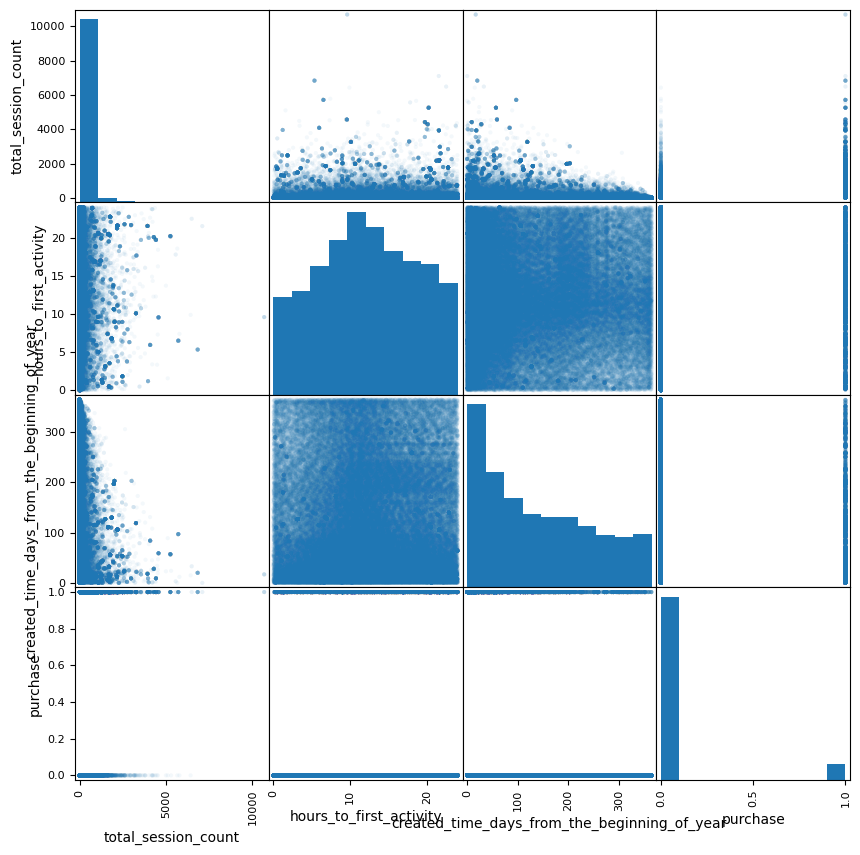

In [45]:
pd.options.mode.chained_assignment = None 
scatter_matrix(merged[eg_col], alpha=0.05, figsize=(10, 10));

In [46]:
merged[eg_col].corr()

,total_session_count,hours_to_first_activity,created_time_days_from_the_beginning_of_year,purchase
total_session_count,1.000000,0.014573,-0.152127,0.602288
hours_to_first_activity,0.014573,1.000000,0.005952,0.022609
created_time_days_from_the_beginning_of_year,-0.152127,0.005952,1.000000,-0.111433
purchase,0.602288,0.022609,-0.111433,1.000000


We see high correlation rate between amount of sessions and purchase, it will be interesting to research, but we also knw that purchase is simply indicator, so anyway we'll tray to explore different clusterisations between our parameters

In [47]:
#extracting sample of data from dataset trying to make it similar to whole dataframe by structure
merged_dropped = merged.drop_duplicates().sample(frac=0.1, replace = False, random_state = 1)
merged_dropped

,account_id,created_time_x,created_device,created_platform,country_code,created_app_store_id,created_country,dates_num,first_activity_date,total_session_count,total_session_duration_sec,hours_to_first_activity,created_time_days_from_the_beginning_of_year,created_time_y,package_id_hash,iap_price_usd_cents,app_store_id,purchase
38592,12897176320,2016-01-07 19:29:49.685,LIFETAB_P891X,Android,DE,2,Germany,52,2016-01-07,94,57495,4.502778,6,2016-03-01 15:28:24.953,99a9e0e63efa2fdce8fc8de74c66cea9,184.0,0.0,1
77924,21486974295,2016-01-02 20:26:20.745,GT-I9301I,Android,IT,2,Italy,1,2016-01-02,1,71,3.560833,1,0,0,0.0,0.0,0
46634,12898525440,2016-03-27 16:00:15.535,"iPhone8,2",iOS,US,1,United States,1,2016-03-27,1,10,7.995556,86,0,0,0.0,0.0,0
74738,30076772184,2016-01-03 15:03:00.060,"iPhone6,2",iOS,SE,1,Sweden,1,2016-01-03,1,468,8.949722,2,0,0,0.0,0.0,0
64392,17193006588,2016-02-22 10:31:24.953,HM 2A,Android,CN,6,China,12,2016-02-22,14,7715,13.476389,52,0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92779,51554137239,2016-08-15 17:21:04.007,vivo X7,Android,CN,16,China,121,2016-08-15,477,142916,6.648611,227,2016-08-15 22:12:31.541,dd4c1bda4f2c904075fb2fbfcf30f30e,369.0,16.0,1
85140,4308415787,2016-02-27 03:48:43.812,PLK-TL01H,Android,CN,8,China,269,2016-02-27,5253,1874606,20.187778,57,2016-10-30 04:45:56.849,99a9e0e63efa2fdce8fc8de74c66cea9,184.0,8.0,1
4952,64438789104,2016-07-26 06:34:50.356,OPPO R9tm,Android,CN,7,China,6,2016-07-26,19,12480,17.419167,207,0,0,0.0,0.0,0
6487,34373263356,2016-04-02 06:10:54.750,SM-G313HZ,Android,VN,2,Viet Nam,2,2016-04-02,8,5247,17.818056,92,0,0,0.0,0.0,0


Data normalisation

In [48]:
from sklearn import preprocessing
dataNorm = preprocessing.MinMaxScaler().fit_transform(merged_dropped[eg_col].values)
dataNorm.shape

(12081, 4)

In [49]:
# Вычислим расстояния между каждым набором данных,
# т.е. строками массива data_for_clust
# Вычисляется евклидово расстояние (по умолчанию)
data_dist = pdist(dataNorm, 'euclidean')
# Главная функция иерархической кластеризии
# Объедение элементов в кластера и сохранение в 
# специальной переменной (используется ниже для визуализации 
# и выделения количества кластеров
data_linkage = linkage(data_dist, method='average')

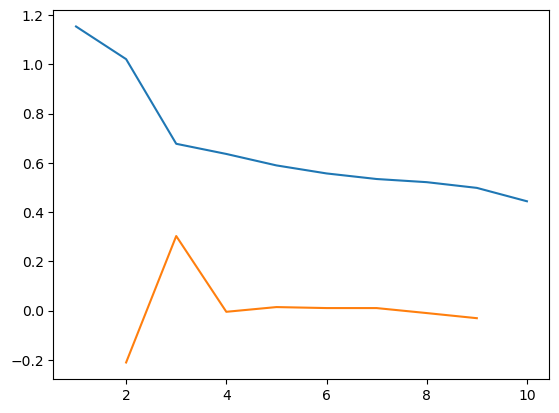

Recommended amount of clusters: 3


In [50]:
# Метод локтя. Позволячет оценить оптимальное количество сегментов.
# Показывает сумму внутри групповых вариаций
last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2 
print("Recommended amount of clusters:", k)

In [51]:
#функция построения дендрограмм
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [52]:
nClust_1=3
nClust_2=7

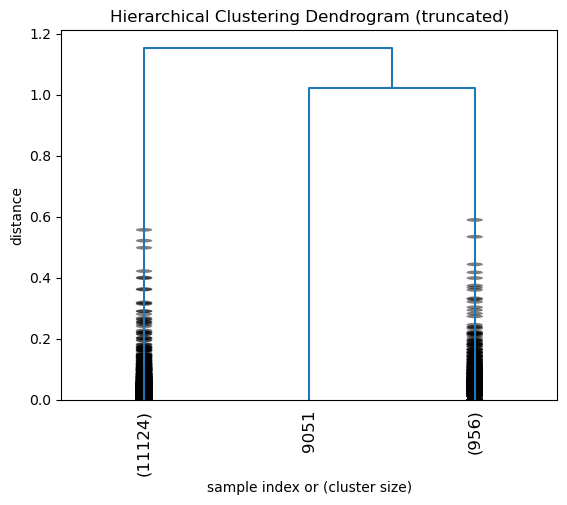

In [53]:
#строим дендрограмму 
fancy_dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=nClust_1, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)
plt.show()

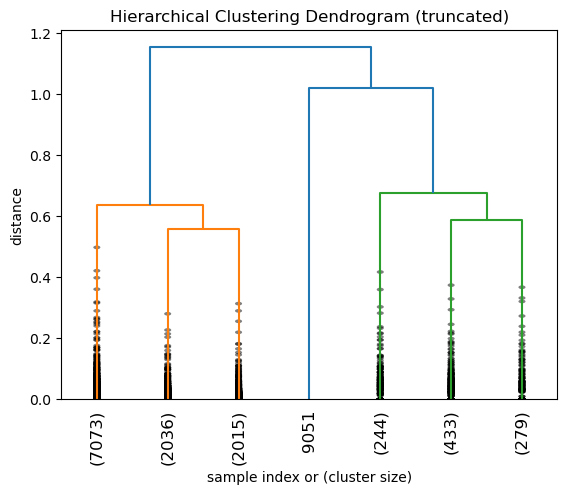

In [54]:
fancy_dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=nClust_2, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)
plt.show()

In [55]:
#выбираю второй вариант
# иерархическая кластеризация
clusters=fcluster(data_linkage, nClust_2, criterion='maxclust')
clusters

array([6, 1, 1, ..., 2, 2, 1], dtype=int32)

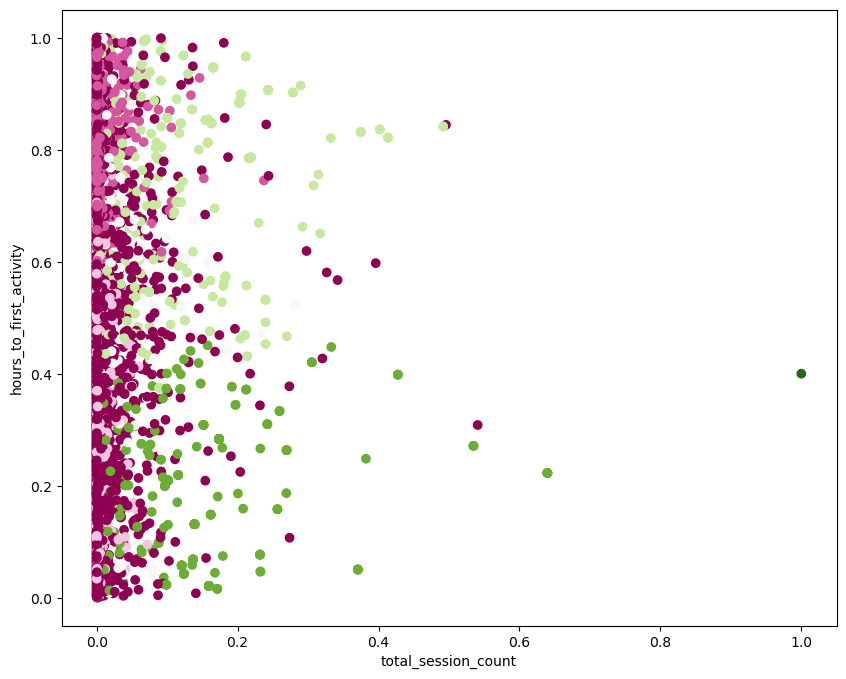

In [56]:
x=0 # Чтобы построить диаграмму в разных осях, меняйте номера столбцов
y=1 #
plt.figure(figsize=(10, 8))
plt.scatter(dataNorm[:,x], dataNorm[:,y], c=clusters, cmap='PiYG')
plt.xlabel(eg_col[x])
plt.ylabel(eg_col[y]);
plt.show()

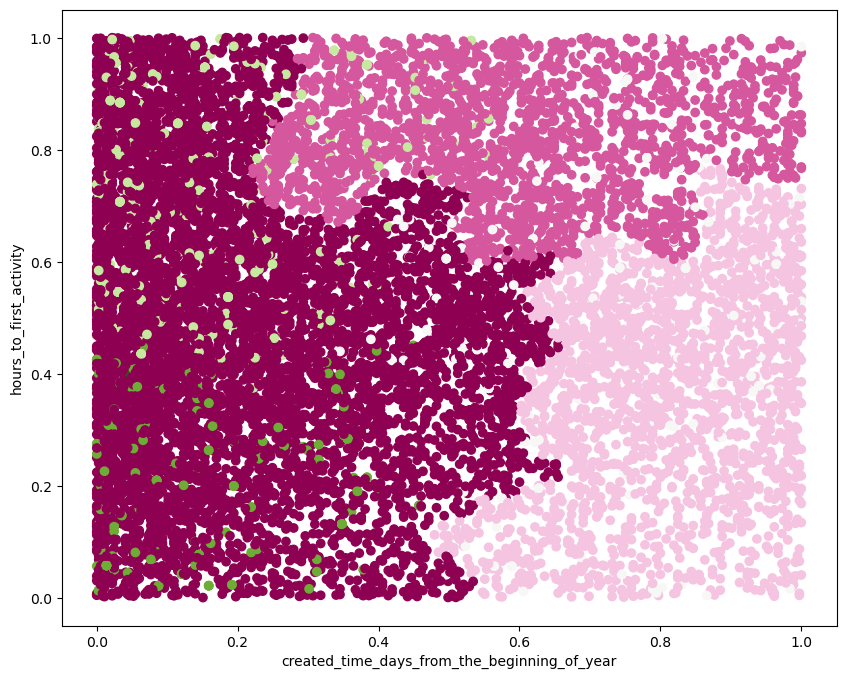

In [57]:
x=2 # Чтобы построить диаграмму в разных осях, меняйте номера столбцов
y=1 #
plt.figure(figsize=(10, 8))
plt.scatter(dataNorm[:,x], dataNorm[:,y], c=clusters, cmap='PiYG')
plt.xlabel(eg_col[x])
plt.ylabel(eg_col[y]);
plt.show()

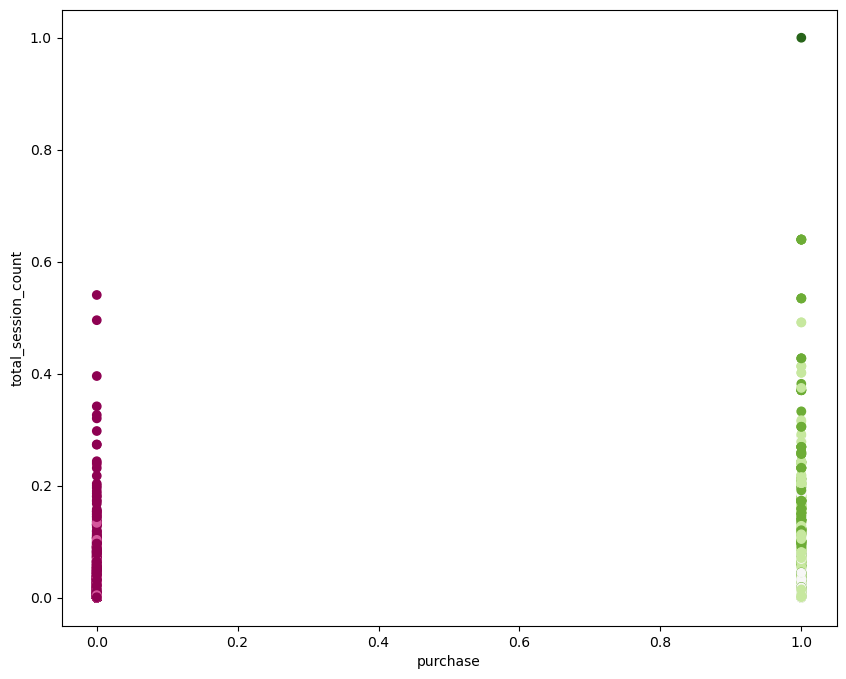

In [58]:
x=3 # Чтобы построить диаграмму в разных осях, меняйте номера столбцов
y=0 #
plt.figure(figsize=(10, 8))
plt.scatter(dataNorm[:,x], dataNorm[:,y], c=clusters, cmap='PiYG')
plt.xlabel(eg_col[x])
plt.ylabel(eg_col[y]);
plt.show()

In [59]:
# к урезаным оригинальным данным добавляем номер кластера
merged_dropped['I']=clusters
merged_res=merged_dropped.groupby('I')[eg_col].mean()
merged_res['amount']=merged_dropped.groupby('I').size().values
merged_res #ниже средние цифры по кластерам и количество объектов (Количество)

,total_session_count,hours_to_first_activity,created_time_days_from_the_beginning_of_year,purchase,amount
I,,,,,
1,53.660681,11.368397,77.692775,0.0,7073
2,35.251965,19.579796,216.983301,0.0,2036
3,21.966749,8.717479,293.980149,0.0,2015
4,465.750000,12.328710,251.676230,1.0,244
5,1010.198614,17.770575,53.438799,1.0,433
6,1390.433692,5.001987,53.724014,1.0,279
7,10683.000000,9.594444,17.000000,1.0,1


In [60]:
merged_dropped[merged_dropped['I']==7] # изучаем наши кластера, в том числе и выбросы

,account_id,created_time_x,created_device,created_platform,country_code,created_app_store_id,created_country,dates_num,first_activity_date,total_session_count,total_session_duration_sec,hours_to_first_activity,created_time_days_from_the_beginning_of_year,created_time_y,package_id_hash,iap_price_usd_cents,app_store_id,purchase,I
69146,12897401403,2016-01-18 14:24:19.262,SM-G925S,Android,KR,2,"Korea, Republic of",348,2016-01-18,10683,2427629,9.594444,17,2016-05-08 03:46:21.189,dd4c1bda4f2c904075fb2fbfcf30f30e,369.0,0.0,1,7


In [61]:
merged.iloc[[15919]]

,account_id,created_time_x,created_device,created_platform,country_code,created_app_store_id,created_country,dates_num,first_activity_date,total_session_count,total_session_duration_sec,hours_to_first_activity,created_time_days_from_the_beginning_of_year,created_time_y,package_id_hash,iap_price_usd_cents,app_store_id,purchase
15919,30079223696,2016-06-22 06:51:08.155,SM-G360HU,Android,PH,2,Philippines,140,2016-06-22,415,148360,17.1475,173,0,0,0.0,0.0,0


In [62]:
from sklearn.cluster import KMeans
km_2 = KMeans(n_clusters=nClust_2).fit(dataNorm)

In [63]:
# выведем полученное распределение по кластерам
# так же номер кластера, к котрому относится строка, так как нумерация начинается с нуля, выводим добавляя 1
km_2.labels_ +1

array([3, 2, 2, ..., 4, 1, 7])

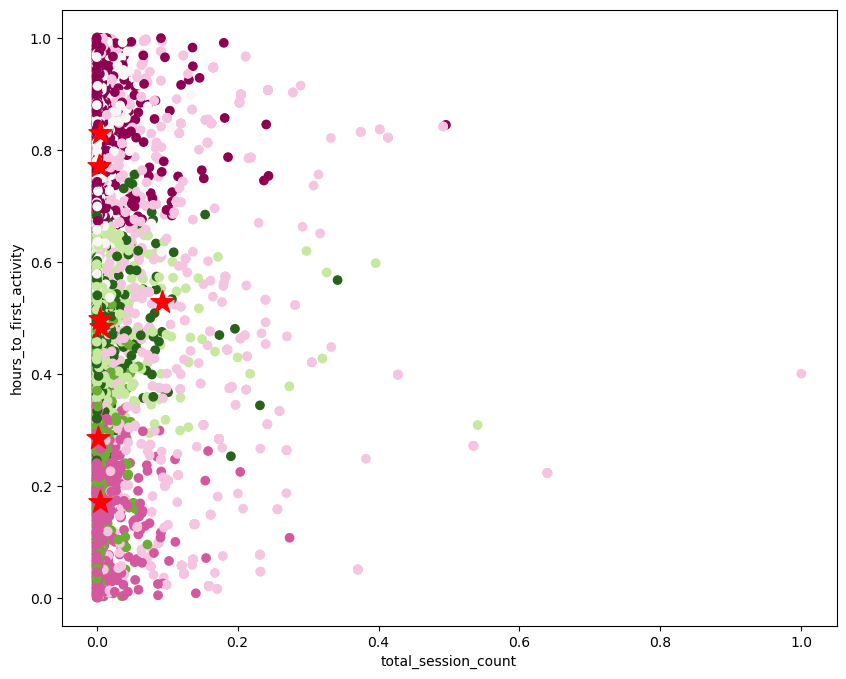

In [64]:
x=0 # Чтобы построить диаграмму в разных осях, меняйте номера столбцов
y=1 #
centroids = km_2.cluster_centers_
plt.figure(figsize=(10, 8))
plt.scatter(dataNorm[:,x], dataNorm[:,y], c=km_2.labels_, cmap='PiYG')
plt.scatter(centroids[:, x], centroids[:, y], marker='*', s=300,
            c='r', label='centroid')
plt.xlabel(eg_col[x])
plt.ylabel(eg_col[y]);
plt.show()


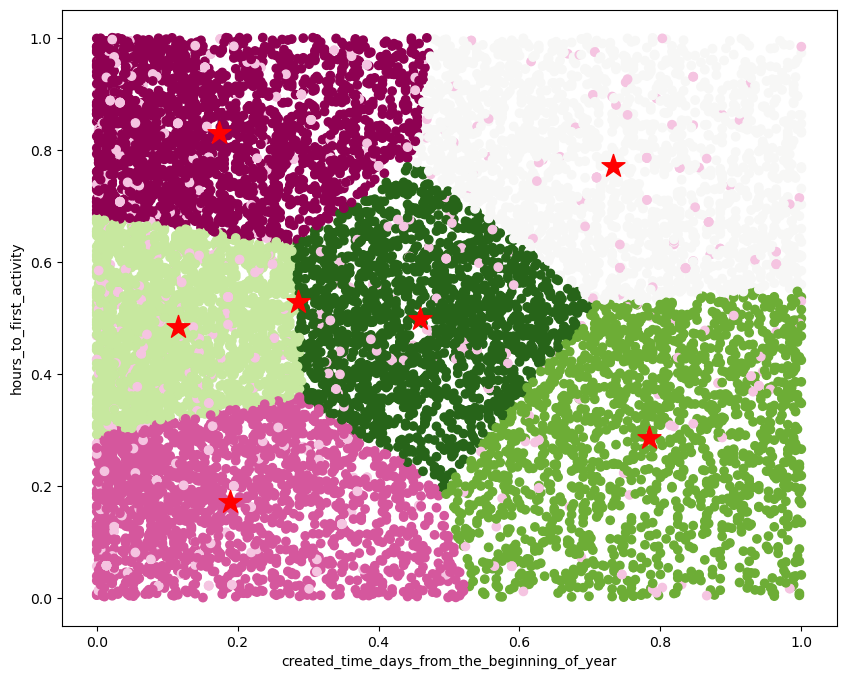

In [65]:
x=2 # Чтобы построить диаграмму в разных осях, меняйте номера столбцов
y=1 #
centroids = km_2.cluster_centers_
plt.figure(figsize=(10, 8))
plt.scatter(dataNorm[:,x], dataNorm[:,y], c=km_2.labels_, cmap='PiYG')
plt.scatter(centroids[:, x], centroids[:, y], marker='*', s=300,
            c='r', label='centroid')
plt.xlabel(eg_col[x])
plt.ylabel(eg_col[y]);
plt.show()

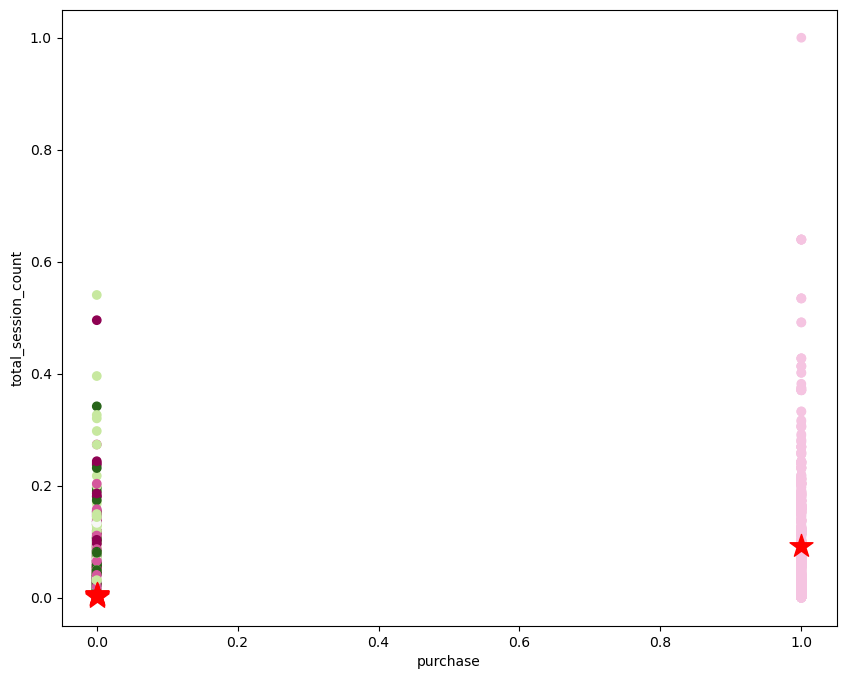

In [66]:
x=3 # Чтобы построить диаграмму в разных осях, меняйте номера столбцов
y=0 #
centroids = km_2.cluster_centers_
plt.figure(figsize=(10, 8))
plt.scatter(dataNorm[:,x], dataNorm[:,y], c=km_2.labels_, cmap='PiYG')
plt.scatter(centroids[:, x], centroids[:, y], marker='*', s=300,
            c='r', label='centroid')
plt.xlabel(eg_col[x])
plt.ylabel(eg_col[y]);
plt.show()

In [67]:
merged_dropped['KMeans']=km_2.labels_+1
res=merged_dropped.groupby('KMeans')[eg_col].mean()
res['quantity']=merged_dropped.groupby('KMeans').size().values
res

,total_session_count,hours_to_first_activity,created_time_days_from_the_beginning_of_year,purchase,quantity
KMeans,,,,,
1,50.773775,19.916001,63.415466,0.0,2082
2,45.365814,4.097577,68.826892,0.0,1837
3,992.343783,12.652052,104.027168,1.0,957
4,29.004413,18.493106,267.640375,0.0,1813
5,67.679061,11.605372,41.883562,0.0,2044
6,23.892091,6.829671,285.963826,0.0,1631
7,44.636575,11.914919,167.707630,0.0,1717


Bla bla bla clusterisation gives us nothing but we tried

Let's create a pivot table for sales analysis, where we define the time of creation from the table with purchases as the time of purchase

In [69]:
total_purchase = pd.merge(iap_df.rename(columns={'created_time':'purchase_time'}),
                             acc_df, 
                             left_on='account_id', right_on='account_id')

total_purchase['purchase_time'] = pd.to_datetime(total_purchase['purchase_time'], format = 'ISO8601')
total_purchase['created_time'] = pd.to_datetime(total_purchase['created_time'], format = 'ISO8601')

#Определяем время между созданием аккаунта и первой покупкой, а так же период относительно начала года
total_purchase['days_from_account_creation'] = (total_purchase['purchase_time'] - total_purchase['created_time']).apply(lambda x: x.days)
total_purchase['days_from_the_beginning_of_year'] = (total_purchase['purchase_time'] - pd.to_datetime('2016-01-01 00:00:00.000')).apply(lambda x: x.days)

In [71]:
total_purchase.days_from_account_creation.describe()

count    9909.000000
mean       68.175093
std        82.122156
min         0.000000
25%         7.000000
50%        32.000000
75%       102.000000
max       360.000000
Name: days_from_account_creation, dtype: float64

Here it's possible to see that 25% of purchases are making at first 7 days since account registration, 50% in next 32 days and 75% of purchases are making in first 102 days since account registration

Let's analyse which purchases users are making

In [72]:
purchases_prices = total_purchase[['iap_price_usd_cents']].sort_values('iap_price_usd_cents', ascending=False)['iap_price_usd_cents'].unique()
purchases_prices

array([3699, 1849,  739,  369,  184,  110,   36], dtype=int64)

Perhaps it's fixed-priced items: there's 6 options of prices in rage from 36 to 3699 cents. Let's see which period range users make purchases since account registration

<Axes: xlabel='iap_price_usd_cents', ylabel='days_from_account_creation'>

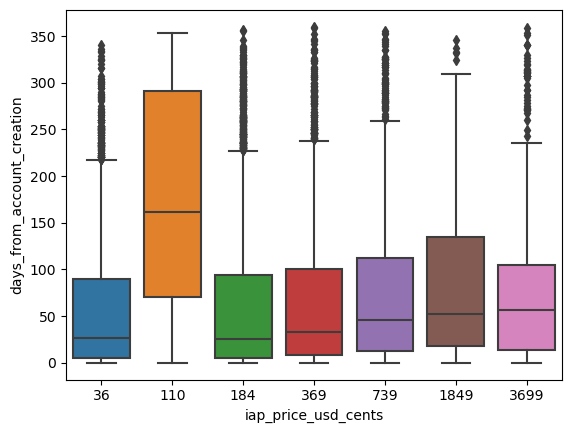

In [73]:
sns.boxplot(data=total_purchase, x='iap_price_usd_cents', y='days_from_account_creation')

Also let's analyse which period since year's beginning users are making purchases, it will possibly identify some seasonal promotions

<Axes: xlabel='iap_price_usd_cents', ylabel='days_from_the_beginning_of_year'>

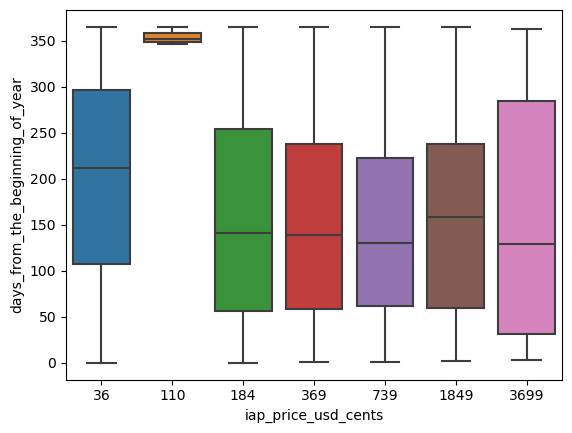

In [74]:
sns.boxplot(data=total_purchase, x='iap_price_usd_cents', y='days_from_the_beginning_of_year')

Here we see that 110 cents item has appeared at the very end of the year, and that's why only long-term registered users buy it. Also it is noted that the purchase peak is located on April-July

Take a look at the distribution of selled items in different countries

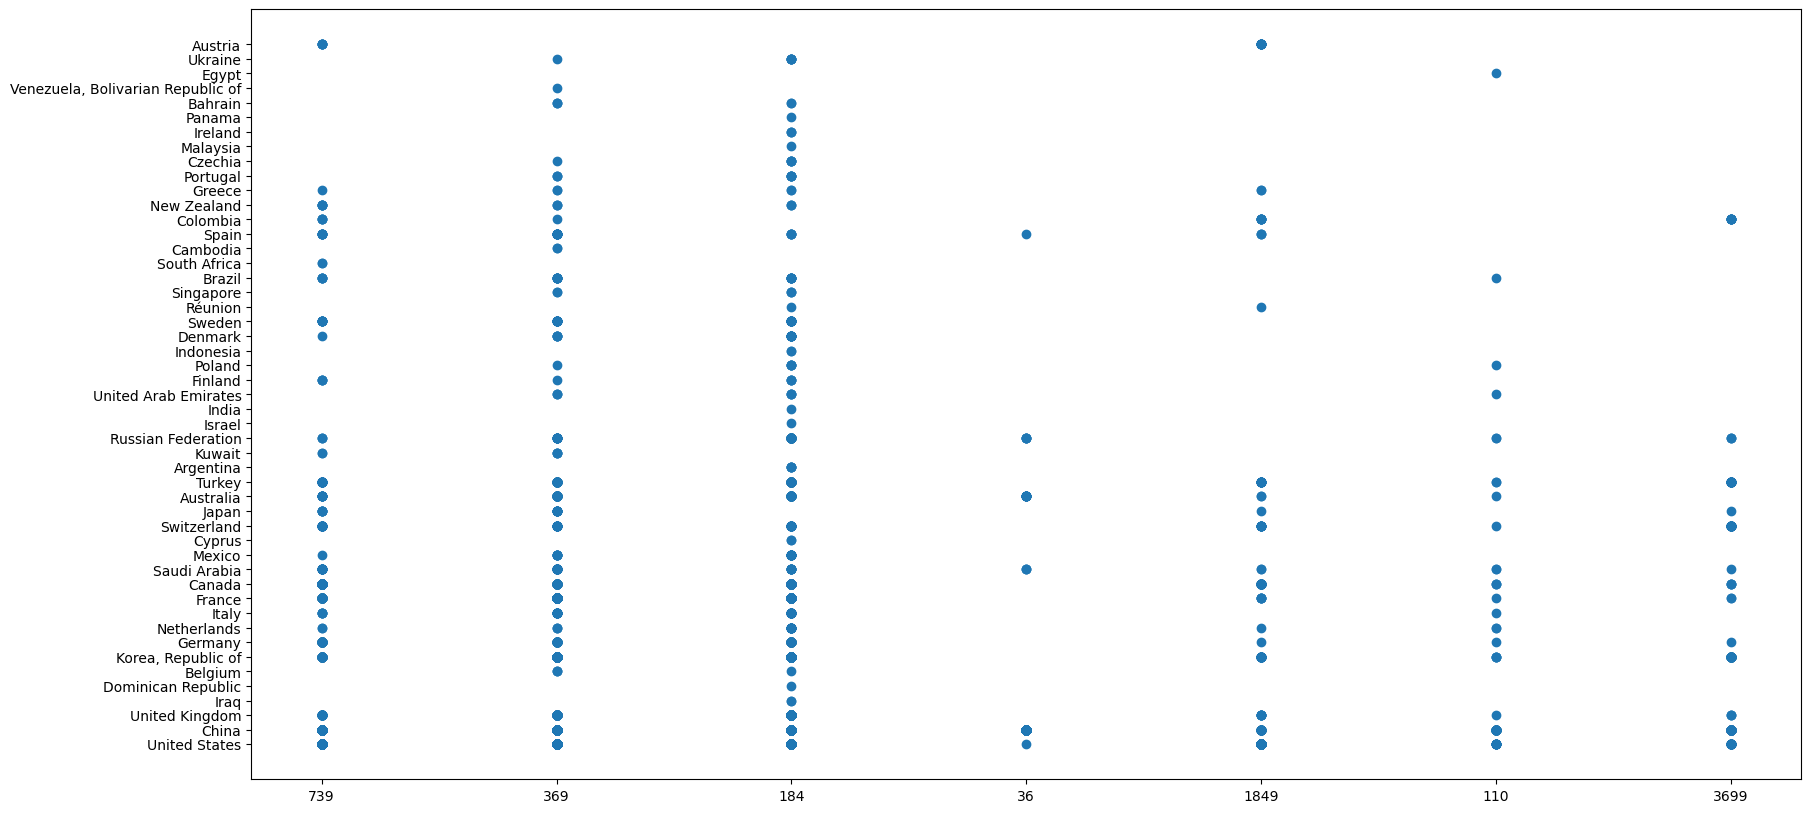

In [75]:
plt.figure(figsize=(20,10))
plt.scatter(total_purchase.dropna(subset=['country_code'])['iap_price_usd_cents'].astype(str), total_purchase.dropna(subset=['country_code'])['created_country'])

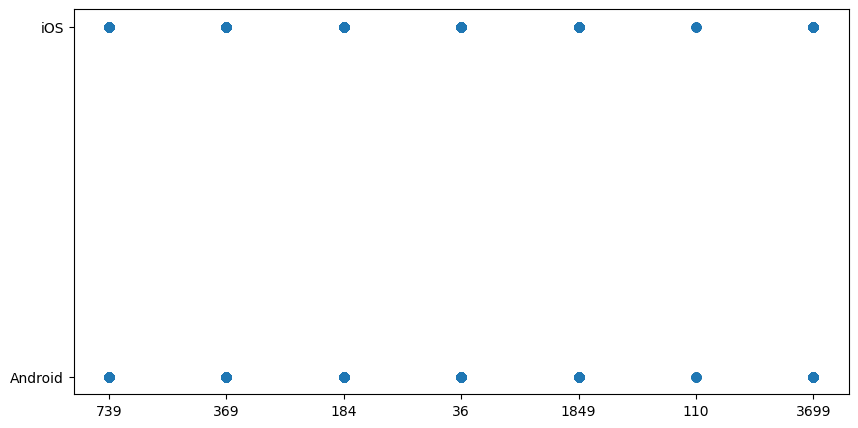

In [76]:
plt.figure(figsize=(10,5))
plt.scatter(total_purchase['iap_price_usd_cents'].astype(str), total_purchase['created_platform'])

Take a look at the share and the amount of each item in the whole mass of purchases

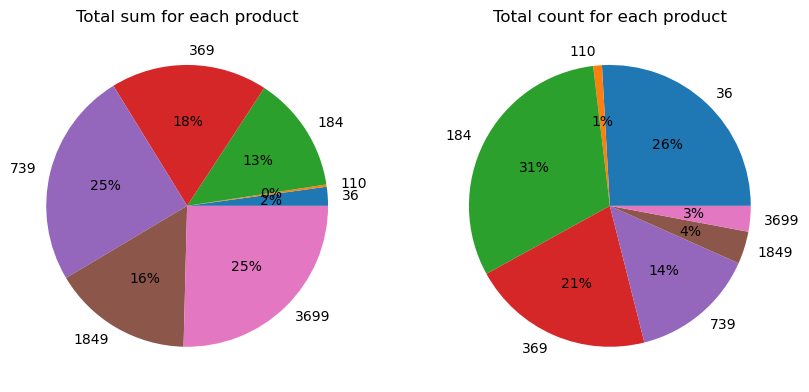

In [77]:
total_sum = total_purchase[['iap_price_usd_cents']].join(total_purchase[['iap_price_usd_cents']].rename(columns={'iap_price_usd_cents':'total_sum'})).groupby('iap_price_usd_cents').sum()
total_count = total_purchase[['iap_price_usd_cents']].join(total_purchase[['iap_price_usd_cents']].rename(columns={'iap_price_usd_cents':'total_count'})).groupby('iap_price_usd_cents').count()

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.title('Total sum for each product')
plt.pie(total_sum.total_sum, labels=total_sum.index.to_list(), autopct='%.0f%%')

plt.subplot(1,2,2)
plt.title('Total count for each product')
plt.pie(total_count.total_count, labels=total_count.index.to_list(), autopct='%.0f%%')
plt.show()

Finally, let's analyze how much money users spend for purchases and how many purchases they makeершают

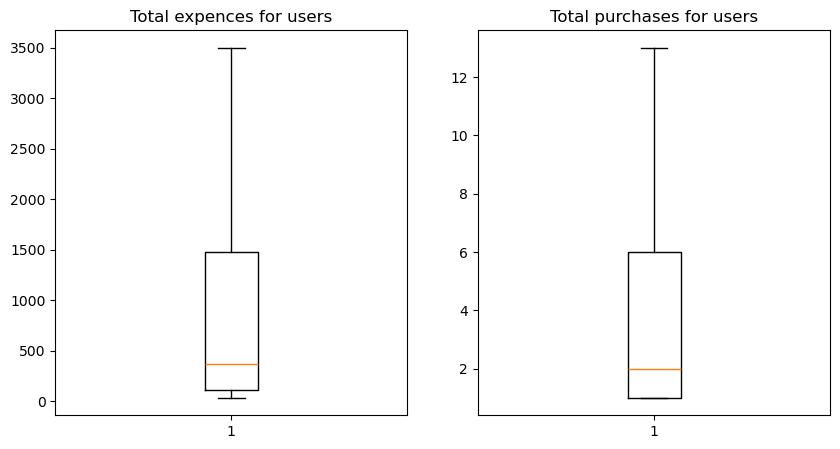

In [79]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.boxplot(total_purchase[['account_id', 'iap_price_usd_cents']].groupby('account_id').sum().iap_price_usd_cents, vert=True, showfliers=False)
plt.title('Total expences for users')

plt.subplot(1,2,2)
plt.boxplot(total_purchase[['account_id', 'iap_price_usd_cents']].groupby('account_id').count().iap_price_usd_cents, vert=True, showfliers=False)
plt.title('Total purchases for users')
plt.show()

In [80]:
total_purchase[['account_id', 'iap_price_usd_cents']].groupby('account_id').sum().rename(columns={'iap_price_usd_cents':'Total expences for users'}).describe()

,Total expences for users
count,1549.000000
mean,2744.907682
std,11350.807645
min,36.000000
25%,110.000000
50%,368.000000
75%,1476.000000
max,247076.000000


In [81]:
total_purchase[['account_id', 'iap_price_usd_cents']].groupby('account_id').count().rename(columns={'iap_price_usd_cents':'Total purchases for users'}).describe()

,Total purchases for users
count,1549.00000
mean,6.39703
std,11.75940
min,1.00000
25%,1.00000
50%,2.00000
75%,6.00000
max,119.00000


Conclusions based on the results of sales analysis:

Among all the products, one stands out - it costs 110 cents. It appeared at the very end of the year, so the share of purchases of this product is relatively small. However, it should be noted that it was purchased by users who registered an account quite a long time ago (approximately from the 80th to the 300th day of account registration). This suggests that the product was in demand, but there was simply not enough data on its sales. In further conclusions, we will exclude this product from consideration.

Users make purchases of existing products within the first 100-150 days after registering an account, and there is a clear trend - the median values increase as the cost of the product increases. Since we see that at the beginning of the year all products already existed, this means that the user needs more time to decide on a more expensive purchase.

Based on the distribution of shares and the number of products in total sales, we conclude that low-cost products are bought more than high-priced products; in total, they bring in less money: the highest income (25% of total income) comes from products costing 3,699 cents and 739 cents. At the same time, users tend to buy not the cheapest product (although the difference in price is significant).

Based on the analysis of purchases by each user, we can conclude that 50% of users make from 1 to 2 purchases, another 25% can make up to 6 purchases, while most likely users will make up to 13 purchases (although the maximum number of purchases made by one user is 119).

Also, based on the analysis of purchases, we can conclude that the minimum user spending is 36 cents (which, in general, is obvious), 25% of users spend up to 110 cents, 50% - up to 368 cents, 75% - up to 1476 cents. In this case, most likely, users will not be willing to spend more than 3,500 cents (although the maximum expenditure made by one user was 247,076 cents).

In [ ]:
Сделой злоключение